# CHAPTER 7.3

### Generating captions for your own photos

we'll use a trained image captioning network to produce textual descriptions of new images.

In [1]:
import glob
import pathlib
import pickle

import os

from tensorflow.keras.preprocessing.image import *
from string import punctuation

import numpy as np
from nltk.translate.bleu_score import corpus_bleu
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.sequence import \
    pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [2]:
#our main class to create datasets and feature extraction
class ImageCaptionFeatureExtractor(object):
    def __init__(self,
                 output_path='.',
                 start_token='beginsequence',
                 end_token='endsequence',
                 feature_extractor=None,
                 input_shape=(224, 224, 3)):
        self.input_shape = input_shape

        if feature_extractor is None:
            input = Input(shape=input_shape)
            self.feature_extractor = VGG16(input_tensor=input,
                                           weights='imagenet',
                                           include_top=False)
        else:
            self.feature_extractor = feature_extractor

        self.output_path = output_path
        self.start_token = start_token
        self.end_token = end_token
        self.tokenizer = Tokenizer()
        self.max_seq_length = None

    def extract_image_features(self, image_path):
        image = load_img(image_path,
                         target_size=self.input_shape[:2])
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        image = preprocess_input(image)

        return self.feature_extractor.predict(image)[0]

    def _clean_captions(self, captions):
        def remove_punctuation(word):
            translation = str.maketrans('', '',
                                        punctuation)
            return word.translate(translation)

        def is_valid_word(word):
            return len(word) > 1 and word.isalpha()

        cleaned_captions = []
        for caption in captions:
            caption = caption.lower().split(' ')
            caption = map(remove_punctuation, caption)
            caption = filter(is_valid_word, caption)

            cleaned_caption = f'{self.start_token} ' \
                              f'{" ".join(caption)} ' \
                              f'{self.end_token}'
            cleaned_captions.append(cleaned_caption)

        return cleaned_captions

    def _get_max_seq_length(self, captions):
        max_sequence_length = -1

        for caption in captions:
            caption_length = len(caption.split(' '))
            max_sequence_length = max(max_sequence_length,
                                      caption_length)

        return max_sequence_length

    def extract_features(self, images_path, captions):
        assert len(images_path) == len(captions)

        captions = self._clean_captions(captions)
        self.max_seq_length = self._get_max_seq_length(captions)
        self.tokenizer.fit_on_texts(captions)

        data_mapping = {}
        print('\nExtracting features...')
        for i in tqdm(range(len(images_path))):
            image_path = images_path[i]
            caption = captions[i]

            feats = self.extract_image_features(image_path)

            image_id = image_path.split(os.path.sep)[-1]
            image_id = image_id.split('.')[0]

            data_mapping[image_id] = {
                'features': feats,
                'caption': caption
            }

        out_path = f'{self.output_path}/data_mapping.pickle'
        with open(out_path, 'wb') as f:
            pickle.dump(data_mapping, f, protocol=4)

        self._create_sequences(data_mapping)

    def _create_sequences(self, mapping):
        num_classes = len(self.tokenizer.word_index) + 1

        in_feats = []
        in_seqs = []
        out_seqs = []

        print('\nCreating sequences...')
        for _, data in tqdm(mapping.items()):
            feature = data['features']
            caption = data['caption']

            seq, = self.tokenizer.texts_to_sequences([caption])

            for i in range(1, len(seq)):
                input_seq = seq[:i]
                input_seq, = pad_sequences([input_seq],
                                           self.max_seq_length)

                # ONE HOT ENCODING
                out_seq = seq[i]
                out_seq = to_categorical([out_seq],
                                         num_classes)[0]

                in_feats.append(feature)
                in_seqs.append(input_seq)
                out_seqs.append(out_seq)

        file_paths = [
            f'{self.output_path}/input_features.pickle',
            f'{self.output_path}/input_sequences.pickle',
            f'{self.output_path}/output_sequences.pickle']
        sequences = [in_feats,
                     in_seqs,
                     out_seqs]

        for path, seq in zip(file_paths, sequences):
            with open(path, 'wb') as f:
                pickle.dump(np.array(seq), f, protocol=4)


In [3]:
def get_word_from_index(tokenizer, index):
    return tokenizer.index_word.get(index, None)




In [4]:
def produce_caption(model,
                    tokenizer,
                    image,
                    max_sequence_length):
    text = 'beginsequence'
    image = np.expand_dims(image, axis=0)

    for _ in range(max_sequence_length):
        sequence = tokenizer.texts_to_sequences([text])[0]
        sequence = pad_sequences([sequence],
                                 maxlen=max_sequence_length)
        print(sequence)
        print(sequence.shape)
        
        print(image.shape)

        prediction = model.predict([[image], sequence])
        index = np.argmax(prediction)

        word = get_word_from_index(tokenizer, index)

        if word is None:
            break

        text += f' {word}'

        if word == 'endsequence':
            break

    return text

In [5]:
extractor_model = VGG16(weights='imagenet')
inputs = extractor_model.inputs
outputs = extractor_model.layers[-2].output
extractor_model = Model(inputs=inputs, outputs=outputs)

extractor = ImageCaptionFeatureExtractor(
    feature_extractor=extractor_model)

In [6]:
with open('data_mapping.pickle', 'rb') as f:
    data_mapping = pickle.load(f)

captions = [v['caption'] for v in data_mapping.values()]

In [7]:
captions

['beginsequence child in pink dress is climbing up set of stairs in an entry way endsequence',
 'beginsequence black dog and spotted dog are fighting endsequence',
 'beginsequence little girl covered in paint sits in front of painted rainbow with her hands in bowl endsequence',
 'beginsequence man lays on bench while his dog sits by him endsequence',
 'beginsequence man in an orange hat starring at something endsequence',
 'beginsequence child playing on rope net endsequence',
 'beginsequence black and white dog is running in grassy garden surrounded by white fence endsequence',
 'beginsequence dog shakes its head near the shore red ball next to it endsequence',
 'beginsequence boy smiles in front of stony wall in city endsequence',
 'beginsequence black dog leaps over log endsequence',
 'beginsequence brown and white dog is running through the snow endsequence',
 'beginsequence man in hat is displaying pictures next to skier in blue hat endsequence',
 'beginsequence collage of one per

In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
max_seq_length = extractor._get_max_seq_length(captions)

In [9]:
max_seq_length

30

In [10]:
model = load_model('model-ep003-loss3.923-val_loss4.260.h5')

In [11]:
import matplotlib.pyplot as plt

captioning_model_2th_notebook.jpg
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]]
(1, 30)
(1, 4096)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  1 10]]
(1, 30)
(1, 4096)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  1 10  3]]
(1, 30)
(1, 4096)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  1 10  3 12]]
(1, 30)
(1, 4096)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  1 10  3 12 31]]
(1, 30)
(1, 4096)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   1 10  3 12 31  7]]
(1, 30)
(1, 4096)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1
  10  3 12 31  7 34]]
(1, 30)
(1, 4096)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1 10
   3 12 31  7 34  6]]
(1, 30)
(1, 4096)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1 10  3
  12 31  7 3

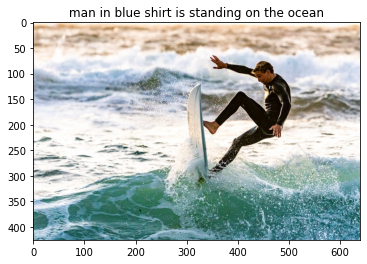

In [12]:
for idx, image_path in enumerate(glob.glob('*.jpg'), start=1):
    print(image_path)
    img_feats = (extractor
                 .extract_image_features(image_path))

    description = produce_caption(model,
                                  tokenizer,
                                  img_feats,
                                  max_seq_length)
    description = (description
                   .replace('beginsequence', '')
                   .replace('endsequence', ''))

    image = plt.imread(image_path)

    plt.imshow(image)
    plt.title(description)
    plt.savefig(f'{idx}.jpg')

With that, we've seen that our model is not good enough, still has room for improvement.
Here are the outputs : 

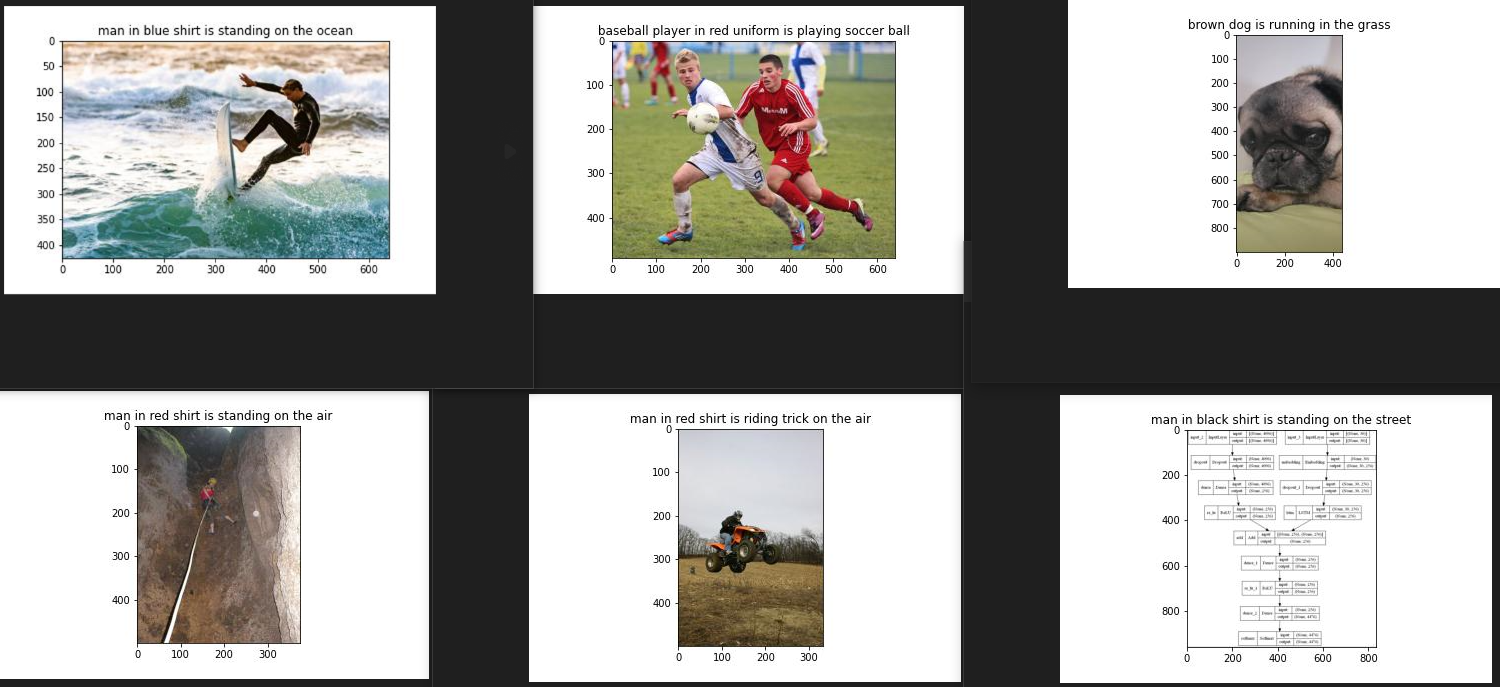